In [1]:
from pytriqs.gf.local import *
from pytriqs.archive import *
from pytriqs.plot.mpl_interface import *
from pytriqs.arrays import *
from pytriqs.gf.local.multivar import *
from glattice_tools.core import *

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
A_ctint={}
ntaus=[200,300]
n=200
niw=64
A_ctint["with"]=HDFArchive("ctint_n_tau_M4t_%s%s.out.h5"%(n,'' if niw==32 else '_niw_64'),'r')
A_ctint["without"]=HDFArchive("ctint_n_tau_M4t_%s%s_g2t.out.h5"%(n,'' if niw==32 else '_niw_64'),'r')
print A_ctint["with"].keys()
A_cthyb=HDFArchive("cthyb.out.h5",'r')

print A_cthyb.keys()


[u'F_tau', u'G0_shift_iw', u'G_2w', u'G_iw', u'M4_iw', u'M4_tau', u'M_iw', u'M_tau', u'chi4_iw', u'hist', u'nn', u'nn_iw', u'nn_tau']
[u'F_tau', u'G_2w', u'G_3w', u'G_iw', u'G_tau', u'nn', u'nn_iw', u'nn_tau']


Postprocessing
--------------------

In [3]:
#postprocessing
n_iw = 64 #number of frequencies in vertex
n_tau_M4t=200
beta = 20.0
block_names = ['up','down']
gf_struct = {block_names[0] : [0], block_names[1] : [0]}
from ctint.postproc import *
P = PostProcessor(beta = beta, gf_struct = gf_struct, n_iw = 200,  n_tau_g0  = 1025, 
                 n_tau_f  = 1025,
                 n_tau_dynamical_interactions = 1025,
                 n_iw_dynamical_interactions = 200,
                 n_tau_M4t = n_tau_M4t,
                 n_w_f_M4w = n_iw, 
                 n_w_b_M4w = n_iw,
                 n_tau_g2t = 2*n_iw+1,
                 n_w_f_g2w = n_iw,
                 n_w_b_g2w = n_iw,
                 n_tau_nnt = 401,
                 )


Starting on 1 Nodes at : 2016-10-20 04:03:14.845769


In [4]:

mm="with"
M4t=A_ctint[mm]["M4_tau"]
M4w=A_ctint[mm]["M4_iw"]
#for n,g in M4w: M4w[n].data[:]=0.0

#M4w = P.M4w_from_M4t(M4t,M4w["up|up|up|up"].mesh)

In [5]:
#chi4w=A_ctint[mm]["chi4_iw"]
#for n,g in chi4w: chi4w[n].data[:]=0.0
Mw=A_ctint[mm]["M_iw"]
g0w_shift=A_ctint[mm]["G0_shift_iw"]
Gw=A_ctint[mm]["G_iw"]
nn=A_ctint[mm]["nn"]

chi4w = P.chi4w_from_M4w(Mw, g0w_shift, M4w)
chi4wconn = P.chi4wconn_from_M4w(Mw, g0w_shift, M4w)

chi4wdisc = P.chi4w_disc_from_gw(Gw, chi4w)

chi4w_2 = chi4wconn + chi4wdisc

g2w=A_ctint[mm]["G_2w"]

g2w = P.g2w_from_chi4w(Gw, chi4w, g2w)

g2w_new = P.g2w_from_chi4wconn(Gw, chi4wconn, g2w, nn)

In [6]:
M4w_conn = P.M4wconn_from_M4w(Mw, M4w)
M4w_irred = P.M4wirred_from_M4wconn(M4w_conn)


In [7]:
chi4wconn_sum= P.sum_chi4wconn_from_M4wconn(Mw, g0w_shift, M4w_conn, g2w)

print chi4wconn_sum["up|up"].data[0,0,0,0,0]

(-0.000755103356654-2.37259133097e-08j)


In [8]:
g2w_new_2 = P.g2w_from_chi4wconn_sum(Gw, chi4wconn_sum, nn)

In [9]:
g2w_new_2["up|up"].data[0,0,0,0,0]

(0.0017396673031098778+0.49969548888688275j)

Three-point function
-----------------------

/home/tayral/Work/TRIQS_1.5/install_gcc6/lib/python2.7/site-packages/pytriqs/gf/local/_gf_common.py:56: UserWarning: g.real is deprecated. Use rather oplot(g, ...., mode = 'R') or oplotr(g, ...)
  warnings.warn("g.real is deprecated. Use rather oplot(g, ...., mode = 'R') or oplotr(g, ...)")
/home/tayral/Work/TRIQS_1.5/install_gcc6/lib/python2.7/site-packages/pytriqs/gf/local/_gf_plot.py:75: UserWarning: oplot: 'RI' flag is deprecated, use 'mode' instead
  warnings.warn("oplot: 'RI' flag is deprecated, use 'mode' instead")
/home/tayral/Work/TRIQS_1.5/install_gcc6/lib/python2.7/site-packages/pytriqs/gf/local/_gf_common.py:61: UserWarning: g.imag is deprecated. Use rather oplot(g, ...., mode = 'I') or oploti(g, ...)
  warnings.warn("g.imag is deprecated. Use rather oplot(g, ...., mode = 'I') or oploti(g, ...)")


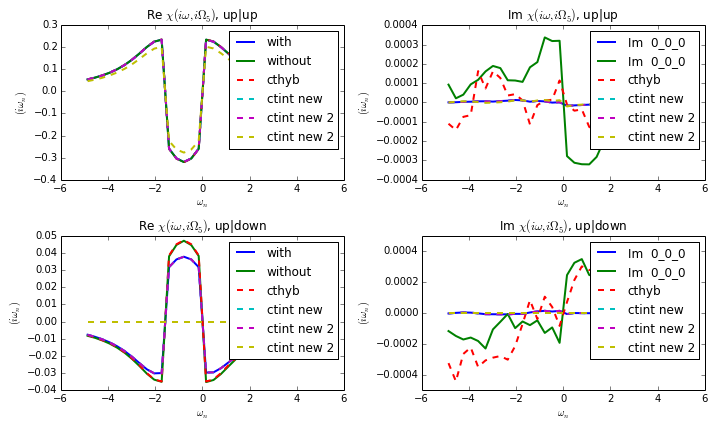

In [10]:
indW=5

############
figure(figsize=(10,6))
gs=GridSpec(2,2)
isub=0
for bl in ["up|up", "up|down"]:
    #####
    subplot(gs[isub]); isub+=1
    title("Re $\chi(i\omega,i\Omega_{%s})$, %s"%(indW,bl))
    for n in ["with","without"] : 
     oplot((1*A_ctint[n]["G_2w"][bl].slice_at_const_w2(indW)[0,0,0]).real, '-', label =r"%s"%n, x_window=(-5,5))

    oplot(A_cthyb["G_2w"][bl].slice_at_const_w2(indW)[0,0,0].real, '--', label="cthyb", x_window=(-5,5))
    
    oplot(g2w[bl].slice_at_const_w2(indW)[0,0,0].real, '--', label="ctint new", x_window=(-5,5))
    oplot(g2w_new[bl].slice_at_const_w2(indW)[0,0,0].real, '--', label="ctint new 2", x_window=(-5,5))
    oplot(g2w_new_2[bl].slice_at_const_w2(indW)[0,0,0].real, '--', label="ctint new 2", x_window=(-5,5))
    #####
    subplot(gs[isub]); isub+=1
    title("Im $\chi(i\omega,i\Omega_{%s})$, %s"%(indW,bl))
    for n in ["with","without"]:
     oplot((1*A_ctint[n]["G_2w"][bl].slice_at_const_w2(indW)[0,0,0]).imag, '-', x_window=(-5,5))
    oplot(A_cthyb["G_2w"][bl].slice_at_const_w2(indW)[0,0,0].imag, '--', label="cthyb", x_window=(-5,5))
    oplot(g2w[bl].slice_at_const_w2(indW)[0,0,0].imag, '--', label="ctint new", x_window=(-5,5))
    oplot(g2w_new[bl].slice_at_const_w2(indW)[0,0,0].imag, '--', label="ctint new 2", x_window=(-5,5))
    oplot(g2w_new_2[bl].slice_at_const_w2(indW)[0,0,0].imag, '--', label="ctint new 2", x_window=(-5,5))
    
tight_layout()

Four-point function
-----------------------

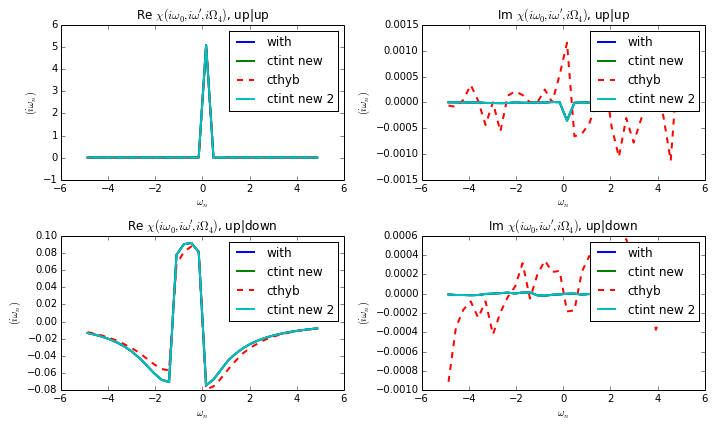

In [9]:
#M4t= A_ctint[n]["M4_tau"]
#print [i for i in M4t.indices]


figure(figsize=(10,6))
gs=GridSpec(2,2)
indW=4
indw=0

isub=0
bl_name = lambda s : "up|up|up|up" if s =="up|up" else "up|up|down|down"
    #####
for bl in ["up|up", "up|down"]:
    subplot(gs[isub]); isub+=1
    title("Re $\chi(i\omega_{%s}, i\omega', i\Omega_{%s})$, %s"%(indw,indW,bl))
    for n in ["with"] : 
     oplot((1*A_ctint[n]["chi4_iw"][bl_name(bl)].slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0]).real,\
           '-', label =r"%s"%n, x_window=(-5,5))

    oplot((chi4w[bl_name(bl)].slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0]).real,\
           '-', label ="ctint new", x_window=(-5,5))
    oplot(A_cthyb["G_3w"][bl].slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0].real, '--', \
          label="cthyb", x_window=(-5,5))
    oplot((chi4w_2[bl_name(bl)].slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0]).real,\
           '-', label ="ctint new 2", x_window=(-5,5))
    
    #####
    subplot(gs[isub]); isub+=1
    title("Im $\chi(i\omega_{%s}, i\omega', i\Omega_{%s})$, %s"%(indw,indW,bl))
    for n in ["with"]:
     oplot((1*A_ctint[n]["chi4_iw"][bl_name(bl)].slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0]).imag,\
           '-',label=n, x_window=(-5,5))
    oplot((chi4w[bl_name(bl)].slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0]).imag,\
           '-', label ="ctint new", x_window=(-5,5))
    oplot(A_cthyb["G_3w"][bl].slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0].imag, '--', \
          label="cthyb", x_window=(-5,5))
    oplot((chi4w_2[bl_name(bl)].slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0]).imag,\
           '-', label ="ctint new 2", x_window=(-5,5))
tight_layout()

/usr/local/install/python-2.7.5/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in divide
/usr/local/install/python-2.7.5/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in divide


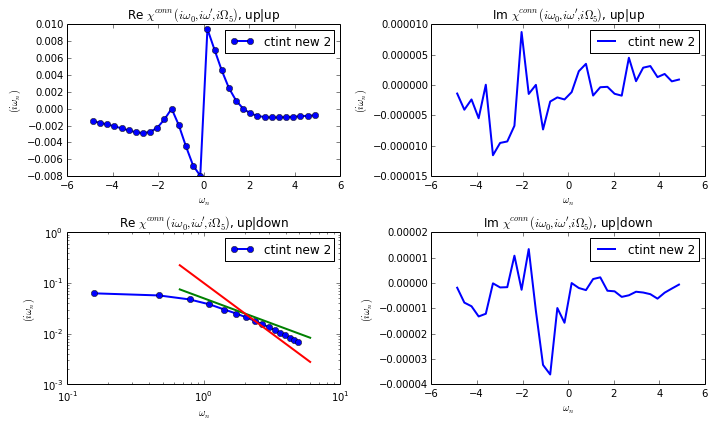

In [29]:
figure(figsize=(10,6))
gs=GridSpec(2,2)
indW=5
indw=0

isub=0
bl_name = lambda s : "up|up|up|up" if s =="up|up" else "up|up|down|down"
    #####
for bl in ["up|up", "up|down"]:
    subplot(gs[isub]); isub+=1
    title("Re $\chi^{conn}(i\omega_{%s}, i\omega', i\Omega_{%s})$, %s"%(indw,indW,bl))
    oplot(((-1*chi4wconn[bl_name(bl)]).slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0]).real,\
           '-o', label ="ctint new 2", x_window=(-5,5))
    if bl=="up|down":
        plot(X,.05/X)
        plot(X,.1/X**2)
        xscale('log')
        yscale('log')
    
    #####
    subplot(gs[isub]); isub+=1
    title("Im $\chi^{conn}(i\omega_{%s}, i\omega', i\Omega_{%s})$, %s"%(indw,indW,bl))
    oplot((chi4wconn[bl_name(bl)].slice_at_const_w3(indW).slice_at_const_w1(indw)[0,0,0,0]).imag,\
           '-', label ="ctint new 2", x_window=(-5,5))
    X=linspace(0,6,10)
tight_layout()

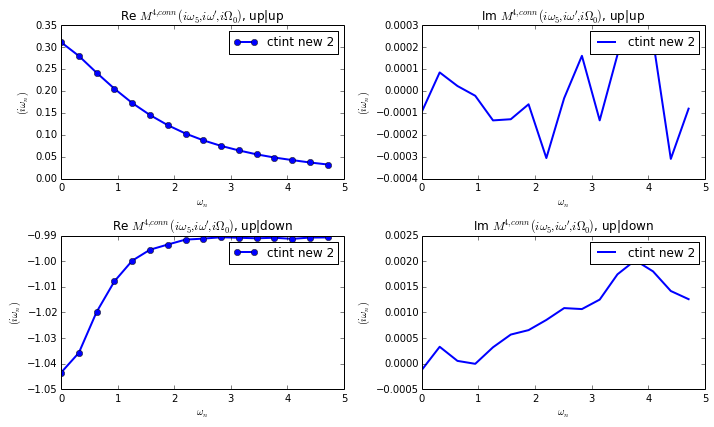

In [34]:

figure(figsize=(10,6))
gs=GridSpec(2,2)
indW=0
indw=5

isub=0
bl_name = lambda s : "up|up|up|up" if s =="up|up" else "up|up|down|down"
    #####
for bl in ["up|up", "up|down"]:
    subplot(gs[isub]); isub+=1
    title("Re $M^{4,conn}(i\omega_{%s}, i\omega', i\Omega_{%s})$, %s"%(indw,indW,bl))
    oplot(((1*M4w_conn[bl_name(bl)]).slice_at_const_w2(62).slice_at_const_w1(indW)[0,0,0,0]).real,\
           '-o', label ="ctint new 2", x_window=(-5,5))
    
    #####
    subplot(gs[isub]); isub+=1
    title("Im $M^{4,conn}(i\omega_{%s}, i\omega', i\Omega_{%s})$, %s"%(indw,indW,bl))
    oplot((M4w_conn[bl_name(bl)].slice_at_const_w2(62).slice_at_const_w1(indW)[0,0,0,0]).imag,\
           '-', label ="ctint new 2", x_window=(-5,5))
    X=linspace(0,6,10)
tight_layout()

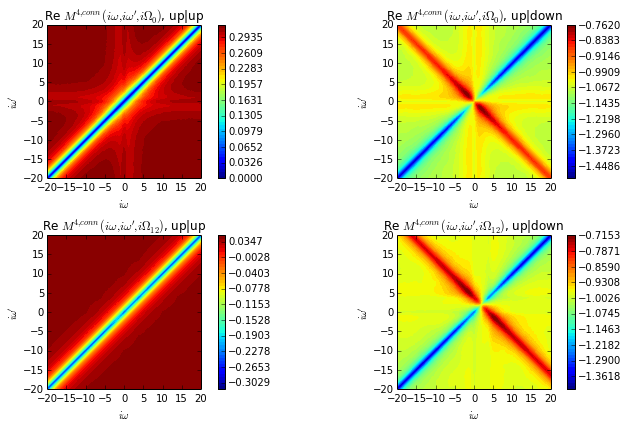

In [12]:

figure(figsize=(10,6))
gs=GridSpec(2,2)

isub=0
bl_name = lambda s : "up|up|up|up" if s =="up|up" else "up|up|down|down"
    #####
for indW in [0,12]:
 for bl in ["up|up", "up|down"]:
    subplot(gs[isub], aspect="equal"); isub+=1
    oplot(M4w_conn[bl_name(bl)].slice_at_const_w3(indW), type="contourf", mode="R")
    title("Re $M^{4,conn}(i\omega, i\omega', i\Omega_{%s})$, %s"%(indW,bl))
    colorbar()
    
tight_layout()
savefig("figures/M4conn.eps",bbox_inches="tight")

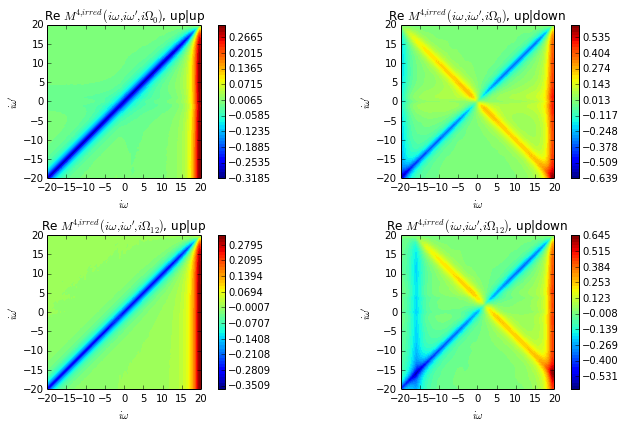

In [ ]:

figure(figsize=(10,6))
gs=GridSpec(2,2)

isub=0
bl_name = lambda s : "up|up|up|up" if s =="up|up" else "up|up|down|down"
    #####
for indW in [0,12]:
 for bl in ["up|up", "up|down"]:
    subplot(gs[isub], aspect="equal"); isub+=1
    oplot(M4w_irred[bl_name(bl)].slice_at_const_w3(indW), type="contourf", mode="R")
    title("Re $M^{4,irred}(i\omega, i\omega', i\Omega_{%s})$, %s"%(indW,bl))
    colorbar()
    
tight_layout()
savefig("figures/M4irred.eps",bbox_inches="tight")

62
62


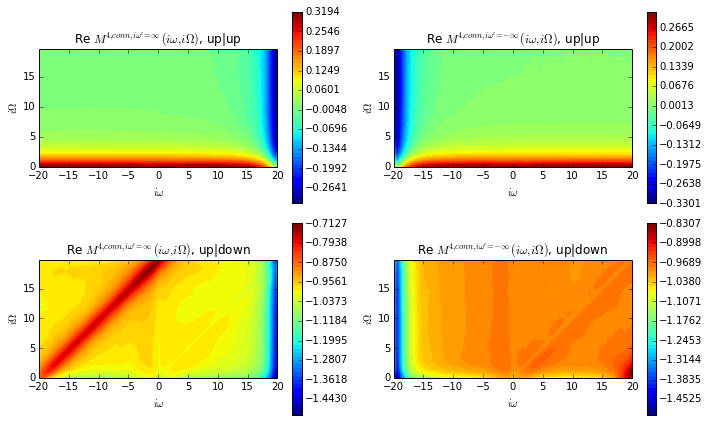

In [37]:

figure(figsize=(10,6))
gs=GridSpec(2,2)

isub=0
bl_name = lambda s : "up|up|up|up" if s =="up|up" else "up|up|down|down"
    #####
for bl in ["up|up", "up|down"]:
    ind_inf = (M4w_conn[bl_name(bl)].mesh.components[1].last_index()-1)
    print ind_inf
    subplot(gs[isub], aspect="equal"); isub+=1
    oplot(M4w_conn[bl_name(bl)].slice_at_const_w2(ind_inf), type="contourf", mode="R")
    title("Re $M^{4,conn, i\omega'=\infty}(i\omega,  i\Omega)$, %s"%(bl))
    colorbar()
    xlabel("$i\omega$")
    ylabel("$i\Omega$")
    subplot(gs[isub], aspect="equal"); isub+=1
    oplot(M4w_conn[bl_name(bl)].slice_at_const_w2(-ind_inf), type="contourf", mode="R")
    title("Re $M^{4,conn, i\omega'=-\infty}(i\omega,  i\Omega)$, %s"%(bl))
    colorbar()
    xlabel("$i\omega$")
    ylabel("$i\Omega$")
    
tight_layout()

Test: $\sum_{i\omega}\chi_{\sigma\sigma'}(i\omega,i\Omega) = \frac{1}{2} \langle n_{\sigma'}\rangle \beta \delta_{i\Omega} - \frac{1}{2} \chi_{\sigma',\sigma}(i\Omega)$

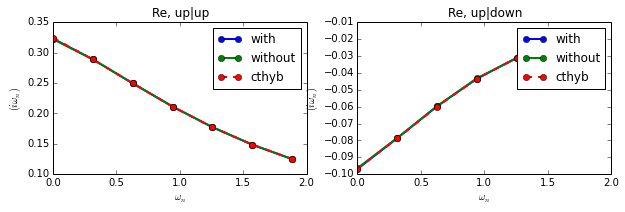

In [4]:

figure(figsize=(10,6))
gs=GridSpec(2,2)
indW=0
isub=0
for bl in ["up|up", "up|down"]:
    #####
    subplot(gs[isub]); isub+=1
    title("Re, %s"%bl)
    for n in ["with","without"] : 
     nn_iw_conn = A_ctint[n]["nn_iw"][bl]   
     nn_iw_conn.data[len(nn_iw_conn.mesh)/2, 0, 0] -= nn_iw_conn.mesh.beta*0.5*0.5
     oplot((1*nn_iw_conn[0,0]).real, '-o', label =r"%s"%n, x_window=(0,2))

    nn_iw_conn = A_cthyb["nn_iw"][bl]   
    nn_iw_conn.data[len(nn_iw_conn.mesh)/2, 0, 0] -= nn_iw_conn.mesh.beta*0.5*0.5
    oplot(nn_iw_conn[0,0].real, '--o', label="cthyb", x_window=(0,2))

Comparison of $\langle n n \rangle$
--------------------------------------

nn= [[ 0.49996872]]
nn= [[ 0.49987363]]
nn= [[ 0.50005197]]
nn= [[ 0.21537873]]
nn= [[ 0.21548535]]
nn= [[ 0.21532951]]


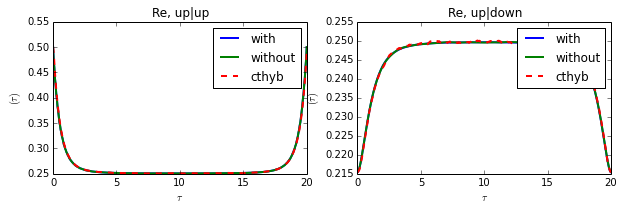

In [5]:

figure(figsize=(10,6))
gs=GridSpec(2,2)
indW=0
isub=0
for bl in ["up|up", "up|down"]:
    #####
    subplot(gs[isub]); isub+=1
    title("Re, %s"%bl)
    for n in ["with","without"] : 
     oplot((1*A_ctint[n]["nn_tau"][bl][0,0]).real, '-', label =r"%s"%n)
     print "nn=",A_ctint[n]["nn"][bl]

    oplot(A_cthyb["nn_tau"][bl][0,0].real, '--', label="cthyb")
    print "nn=",A_cthyb["nn"][bl]


Comparison of $G$
--------------------------------------

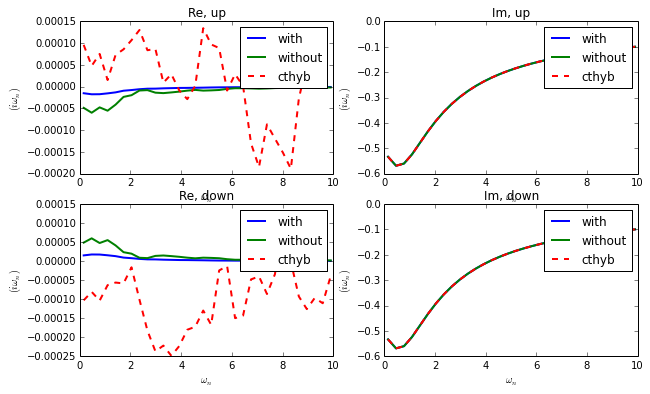

In [27]:

figure(figsize=(10,6))
gs=GridSpec(2,2)
indW=0
isub=0
for bl in ["up","down"]:
    #####
    subplot(gs[isub]); isub+=1
    title("Re, %s"%bl)
    for n in ["with","without"] : 
     oplot((1*A_ctint[n]["G_iw"][bl][0,0]).real, '-', label =r"%s"%n, x_window=(0,10))

    oplot(A_cthyb["G_iw"][bl][0,0].real, '--', label="cthyb", x_window=(0,10))
    subplot(gs[isub]); isub+=1
    title("Im, %s"%bl)
    for n in ["with","without"] : 
     oplot((1*A_ctint[n]["G_iw"][bl][0,0]).imag, '-', label =r"%s"%n, x_window=(0,10))

    oplot(A_cthyb["G_iw"][bl][0,0].imag, '--', label="cthyb", x_window=(0,10))